## Challenge: Model Comparison

In [1]:
import math
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from sklearn import linear_model
import seaborn as sns
import statsmodels.formula.api as smf
from sklearn.decomposition import PCA 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler 
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_selection import SelectKBest

%matplotlib inline

#path = 'https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/master/New_York_offenses/NEW_YORK-Offenses_Known_to_Law_Enforcement_by_City_2013%20-%2013tbl8ny.csv'
NY_crime_2013 = pd.read_excel("table_8_offenses_known_to_law_enforcement_new_york_by_city_2013.xls", header=None, skiprows=5)


In [2]:
# Load the first data set and prepare for analysis 
NY_crime_2013.columns = ['City', 'Population', 'Violent', 'Murder', 'Rape_def1', 'Rape_def2', 'Robbery', 'Aggravated'
              , 'Property_crime', 'Burglary', 'Larceny', 'Motor_vehicle_teft', 'Arson']

In [3]:
# drop Rape_def1 as it contains no information, almost half of Arson variable is nan as well
NY_crime_2013 = NY_crime_2013.drop('Rape_def1', axis=1)
NY_crime_2013 = NY_crime_2013.drop('Arson', axis=1)

In [6]:
NY_crime_2013.sort_values(by=['Population'], ascending=False).head(10)

,City,Population,Violent,Murder,Rape_def2,Robbery,Aggravated,Property_crime,Burglary,Larceny,Motor_vehicle_teft
216,New York,8396126.0,52384.0,335.0,1112.0,19170.0,31767.0,141971.0,16606.0,117931.0,7434.0
35,Buffalo,258789.0,3249.0,47.0,145.0,1322.0,1735.0,12491.0,3458.0,8076.0,957.0
272,Rochester,210562.0,2107.0,42.0,92.0,918.0,1055.0,10051.0,2587.0,6855.0,609.0
346,Yonkers,199134.0,1036.0,6.0,25.0,390.0,615.0,2368.0,470.0,1662.0,236.0
310,Syracuse,143834.0,1192.0,21.0,75.0,400.0,696.0,6473.0,1781.0,4298.0,394.0
7,Amherst Town,118296.0,107.0,1.0,7.0,31.0,68.0,2118.0,204.0,1882.0,32.0
3,Albany,97956.0,791.0,8.0,30.0,227.0,526.0,4090.0,705.0,3243.0,142.0
126,Greece Town,96667.0,151.0,0.0,9.0,60.0,82.0,2303.0,332.0,1925.0,46.0
267,Ramapo Town,87204.0,57.0,2.0,5.0,9.0,41.0,567.0,88.0,466.0,13.0
57,Clarkstown Town,80705.0,65.0,0.0,8.0,17.0,40.0,1515.0,99.0,1388.0,28.0


Most of the cities have a population of less than 40000. Cities like New York have very high population and we will drop those columns to reduce outliers.   

In [7]:
NY_crime_2013.drop(NY_crime_2013[NY_crime_2013.Population > 40000].index, inplace=True)
#df.drop(df[df.score < 50].index, inplace=True)

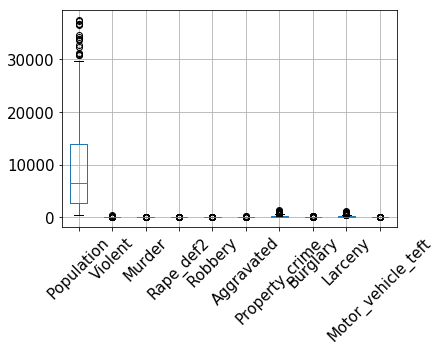

In [10]:
boxplot = NY_crime_2013.boxplot(grid=True, rot=45, fontsize=15)

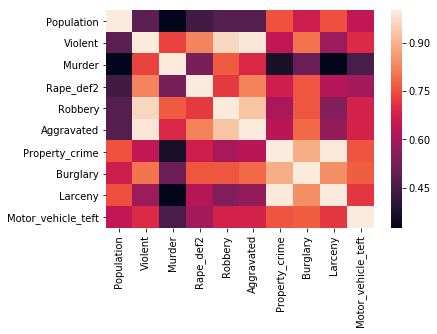

In [11]:
sns.heatmap(NY_crime_2013.corr())

There is high collinearity in the data. we will use pca to reduce it before building the model 

In [12]:
NY_crime_2013 = NY_crime_2013[['Population','Violent', 'Murder', 'Rape_def2', 'Robbery', 'Property_crime', 'Burglary']]#.dropna()


In [13]:
NY_crime_2013.shape

(321, 7)

In [14]:
# replaceing NaN values with the median would be better than dropping them here
NY_crime_2013 = NY_crime_2013.fillna(NY_crime_2013.median())

In [15]:
# Extract dependent and independent variables and create a data set with only the features we need 
X = NY_crime_2013[['Population','Violent', 'Murder', 'Rape_def2', 'Robbery', 'Burglary']]

X.head()

,Population,Violent,Murder,Rape_def2,Robbery,Burglary
0,1861.0,0.0,0.0,0.0,0.0,2.0
1,2577.0,3.0,0.0,0.0,0.0,3.0
2,2846.0,3.0,0.0,0.0,0.0,1.0
4,6388.0,23.0,0.0,3.0,4.0,53.0
5,4089.0,5.0,0.0,0.0,3.0,10.0


In [16]:
# This is the variable we want to predict 
Y = NY_crime_2013['Property_crime']#[:263]

Now that the data set is ready, we'll start comparing models by first apply OLS and KNN models on the raw data

### Linear regression on the raw data

In [17]:
# let's split the data in to training and test
# the _r in the name indicates raw data 
from sklearn.model_selection import train_test_split
x_train_r, x_test_r, y_train_r, y_test_r = train_test_split(X, Y, test_size = 0.2, random_state = 0)

In [18]:
# fit the data
regressor = LinearRegression()
regressor.fit(x_train_r, y_train_r)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [19]:
Yr_ = regressor.predict(x_test_r)

In [20]:
from sklearn.model_selection import cross_val_score
score = cross_val_score(regressor, X, Y, cv=5)
print(score)

[0.91087723 0.82111931 0.82175813 0.75763146 0.79602159]


In [21]:
from sklearn.metrics import r2_score
r2_score(y_test_r, Yr_)

0.820468274691271

In [22]:
print('MSE:', mean_squared_error(y_test_r, Yr_))

MSE: 6095.579522388878


###  KNN regression with the raw data 

In [49]:
from sklearn import neighbors
knn = neighbors.KNeighborsRegressor(n_neighbors=14)
knn.fit(X, Y)
KYr_ = knn.predict(x_test_r)

In [50]:
from sklearn.model_selection import cross_val_score
score_K = cross_val_score(knn, X, Y, cv=5)
print(score_K)

[0.6531442  0.44539167 0.55596235 0.61286388 0.59574899]


In [51]:
from sklearn.metrics import r2_score
r2_score(y_test_r, KYr_)

0.7601336700658976

In [52]:
print('MSE:', mean_squared_error(y_test_r, KYr_))

MSE: 8144.099803767662


The KNN regression model has a better r squared, and MSE values. The cross validation shows almost similar fluctuation in the score. 

#### Now lets apply PCA and SelectbestK on the data before running the model 

### Linear regression on the components

In [27]:
pca = PCA(n_components=4)

In [28]:
selection = SelectKBest(k=1)

In [29]:
combined_features = FeatureUnion([("pca", pca), ("univ_select", selection)])

In [30]:
X_features = combined_features.fit(X, Y).transform(X)

In [31]:
# let's split the data in to training and test  
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X_features, Y, test_size = 0.2, random_state = 0)

In [32]:
# fit the data
regressor = LinearRegression()
regressor.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [33]:
Y_ = regressor.predict(x_test)

In [53]:
from sklearn.model_selection import cross_val_score
score2 = cross_val_score(regressor, X_features, Y, cv=5)
print(score2)

[0.90957422 0.81749889 0.83544174 0.74718899 0.79477382]


In [54]:
from sklearn.metrics import r2_score
r2_score(y_test, Y_)

0.8301407011970632

In [55]:
print('MSE:', mean_squared_error(y_test, Y_))

MSE: 5767.174919586058


### KNN regression on the components 


In [37]:
knn.fit(x_train, y_train)


KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=14, p=2,
          weights='uniform')

In [38]:
KY_ = knn.predict(x_test)

In [39]:
from sklearn.model_selection import cross_val_score
score_K2 = cross_val_score(knn, X_features, Y, cv=5)
print(score_K2)

[0.6531442  0.44539167 0.55596235 0.61286388 0.59574899]


In [40]:
from sklearn.metrics import r2_score
r2_score(y_test, KY_)

0.726749315570743

In [41]:
print('MSE:', mean_squared_error(y_test, KY_))

MSE: 9277.587421507063


### Check for homoscedassticity and normality 

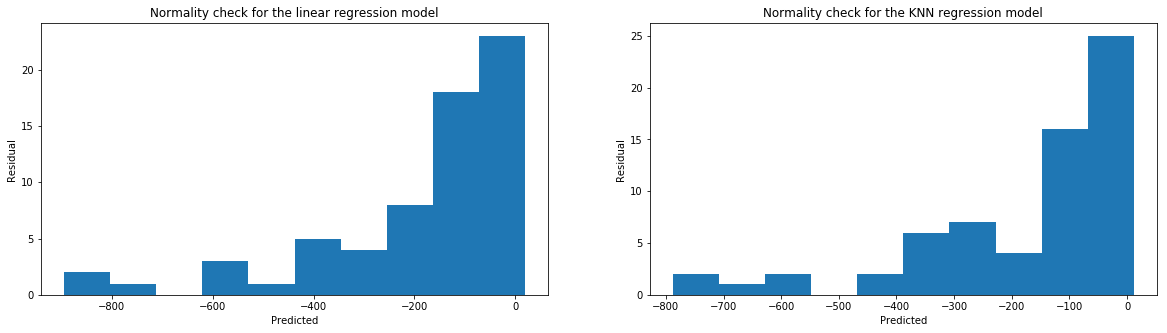

In [42]:
# Normality test
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
actual = Y
predicted = Y_
residual = actual[len(predicted)] - predicted # length of actual is different from
# predicted because of the holdout split
plt.hist(residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.title('Normality check for the linear regression model')

plt.subplot(1, 2, 2)
actual_k = Y
predicted_k = KY_
residual_k = actual_k[len(predicted_k)] - predicted_k # length of actual is different from
# predicted because of the holdout split
plt.hist(residual_k)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.title('Normality check for the KNN regression model')

plt.show()



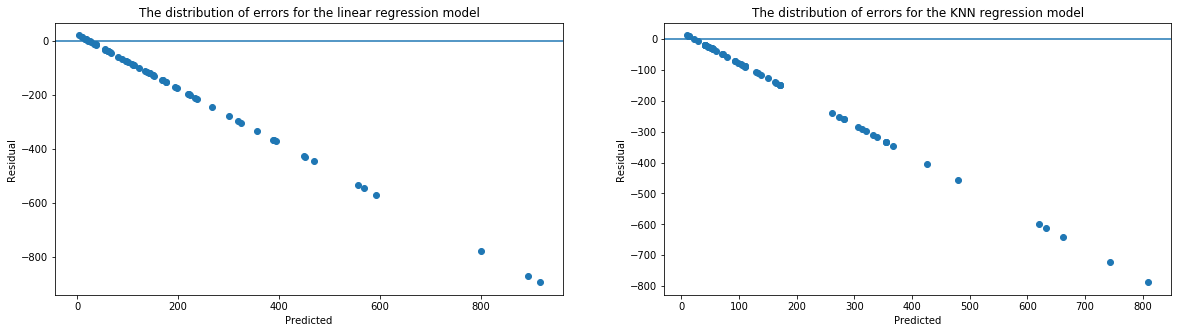

In [43]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('The distribution of errors for the linear regression model')

plt.subplot(1, 2, 2)
plt.scatter(predicted_k, residual_k)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('The distribution of errors for the KNN regression model')
plt.show()

### In conclusion 

The models behave similar to each other. KNN has a slightly better r squared value and almost equally consistent cross validation score both on the raw data and on the components after pca and selectkbest methods are applied. MSE values are higher for both models. The Population variable still has many outlier values which lie outside the 1.5 quartile range and I suspect that could be one of the reason why we get fluctuating cross validation and high MSE scores. The other reson being the multicolinearity in the data as shown in the heatmap. 

The difference in the results is not conclusive enough to choose one over the other. 

